Task 2 :  

# Classification of Novel Classes Using Neural Networks

This notebook explores the performance of Bayesian and Classical Neural Networks in multiclass classification tasks, particularly focusing on identifying novel (unseen) classes during testing using uncertainty quantification.

---

## 1. Data Preparation
The dataset used for this experiment is a multiclass classification dataset with at least four distinct classes. The following steps are performed to prepare the data:
- **Dataset Splitting**: The dataset is split into training, validation, and testing subsets. One class is excluded entirely from training to simulate the detection of novel classes. This excluded class is added to the test set.
- **Tensor Conversion**: Features and labels are converted into PyTorch tensors to facilitate compatibility with PyTorch-based models.

---

## 2. Bayesian Neural Network (BNN) Implementation
The Bayesian Neural Network (BNN) is implemented using PyMC. Probabilistic modeling enables uncertainty quantification and novel class detection:
- **Posterior Predictive Inference**: The model generates posterior predictive distributions for test samples. These predictions are used to calculate uncertainty for each sample.
- **Novel Class Detection**: Samples with uncertainty above a threshold (e.g., 1.0) are classified as belonging to a novel class.
- **Evaluation**: Metrics include the number of total samples and the number classified as unknown.

### Key Observations:
- BNNs effectively flag novel samples using uncertainty-based thresholds.
- Probabilistic modeling is well-suited for tasks requiring reliable detection of outliers or novel inputs.

---

## 3. Classical Neural Network (NN) Implementation
The classical neural network, implemented in PyTorch, is designed to classify known classes and compare against the Bayesian approach.

### Network Architecture:
- **Input Layer**: Matches the number of features in the dataset.
- **Hidden Layers**: Two hidden layers (256 and 64 neurons) with ReLU activation.
- **Output Layer**: Softmax activation for multiclass probability predictions.

### Training Process:
- **Loss Function**: CrossEntropyLoss computes the error between predicted and actual class labels.
- **Optimizer**: Adam optimizer (learning rate = 0.002) updates model parameters.
- **Batch Training**: The model trains on data in mini-batches (batch size = 32).
- **Epochs**: Training progresses for 5 epochs with performance monitored using validation accuracy and loss metrics.

---

## 4. Model Evaluation and Comparison

### Bayesian Neural Network:
- **Novel Class Detection**: The thresholding approach detects novel samples. Out of 196 test samples, 35 were classified as unknown.
- **Advantages**:
  - Precise uncertainty quantification.
  - High reliability in detecting unseen inputs.
- **Limitations**: Computational overhead due to probabilistic sampling.

### Classical Neural Network:
- **Test Accuracy**: Achieved a high accuracy of 97.24% on known classes in the test set.
- **Limitations**: Does not natively support uncertainty quantification, making it unsuitable for novel class detection without additional mechanisms.

---

## 5. Results Summary

| **Model**               | **Metric**                    | **Value**    |
|--------------------------|-------------------------------|--------------|
| **Bayesian Neural Network** | Test samples classified as unknown | 35           |
|                          | Test accuracy (familiar classes)    | N/A          |
| **Classical Neural Network** | Test accuracy (familiar classes)    | 97.24%       |
|                          | Novel class detection supported      | No           |

---

## 6. Future Directions
1. **Uncertainty Calibration**: Investigate alternative methods for calibrating uncertainty thresholds in BNNs.
2. **Hybrid Approaches**: Combine classical and Bayesian models to leverage strengths of both methods.
3. **Scalability**: Explore techniques to reduce computational cost of Bayesian inference for larger datasets.

By quantifying uncertainty and comparing probabilistic and classical neural networks, this project demonstrates the importance of Bayesian methods for detecting novel classes while maintaining robust performance on familiar data.


In [ ]:
# ! pip install pymc
# ! pip install pytensor


In [ ]:
# Standard library imports
import numpy as np

# Third-party library imports
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, OneHotEncoder
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler


# PyMC and PyTensor imports
import pymc as pm
import pymc.math as pmath
import pytensor

# ArviZ imports
import arviz as az


In [ ]:
SEED = 7735
rng = np.random.default_rng(SEED)

floatX = pytensor.config.floatX

The dataset I used in this project is the Digits dataset, which is part of the sklearn library. It contains 8x8 pixel images of handwritten digits, each represented as a 64-dimensional feature vector (flattened pixel values). The dataset includes 10 classes (digits 0 through 9), but for this project, we focused on a subset of classes—digits 0, 1, 2, 3, and 4—for training, validation, and testing. This subset consists of 901 samples, each with 64 features. Additionally, digit 6 was omitted from training and validation, but a separate set of 181 samples was kept to test the model on out-of-distribution (OOD) data.

The dataset was divided into three subsets: 576 samples for training, 144 for validation, and 181 for testing. The OOD dataset was not used in training or validation but will be used during testing to assess the model's performance on unseen data.

Prior to splitting, all features were standardized using StandardScaler. The scaler was fit on the training data to compute the mean and standard deviation, which were then applied to transform the validation, test, and OOD datasets. This standardization ensures that all features are on the same scale, preventing any single feature from dominating due to differences in numeric ranges.

In [ ]:
data, labels = load_digits(return_X_y=True)
print(data.shape)
print(labels.shape)
print(labels)

(1797, 64)
(1797,)
[0 1 2 ... 8 9 8]


In [ ]:
# Define the selected classes (digits 0 to 4)
selected_classes = [0, 1, 2, 3, 4]

# Create a mask to filter the data and labels, selecting only samples from the selected classes
mask = [label in selected_classes for label in labels]
X_filtered = data[mask]  # Apply the mask to the feature data
y_filtered = labels[mask]  # Apply the mask to the labels

print(f"X_filtered shape: {X_filtered.shape}")
print(f"y_filtered shape: {y_filtered.shape}")

# Create a separate set for the samples with label 6 (out-of-distribution data)
X_omitted = data[labels == 6]  # Select samples with label 6
y_omitted = labels[labels == 6]  # Select the corresponding labels

print(f"X_omitted shape: {X_omitted.shape}")
print(f"y_omitted shape: {y_omitted.shape}")
print()

# Split the filtered data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

# Initialize the StandardScaler to standardize the features
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_omitted = scaler.transform(X_omitted)

# Convert the data arrays to the specified floating-point format
X_train = X_train.astype(floatX)
X_val = X_val.astype(floatX)
X_test = X_test.astype(floatX)
X_omitted = X_omitted.astype(floatX)

print(f"X_train_scaled shape: {X_train.shape}")
print(f"X_val_scaled shape: {X_val.shape}")
print(f"X_test_scaled shape: {X_test.shape}")


X_filtered shape: (901, 64)
y_filtered shape: (901,)
X_omitted shape: (181, 64)
y_omitted shape: (181,)

X_train_scaled shape: (576, 64)
X_val_scaled shape: (144, 64)
X_test_scaled shape: (181, 64)


Class ratios for Training:



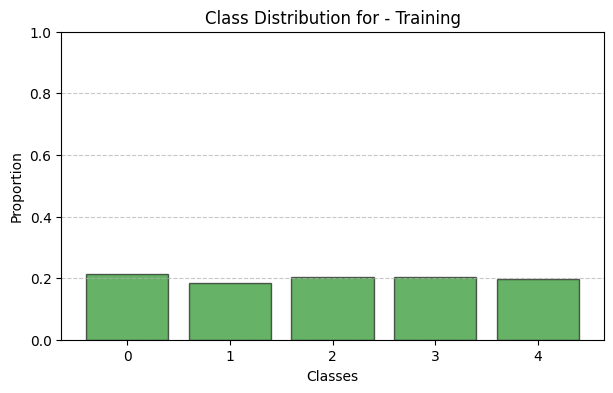

Class ratios for Test:



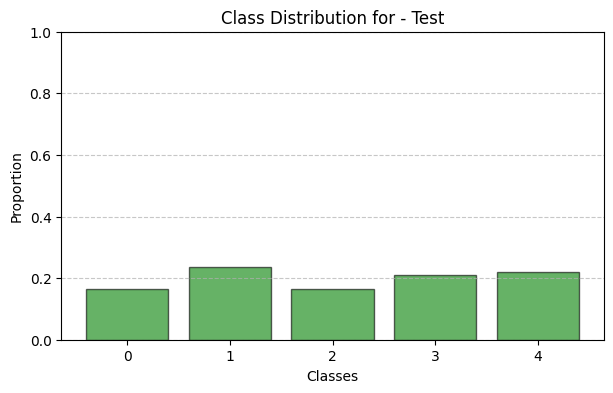

Class ratios for Eliminated class:



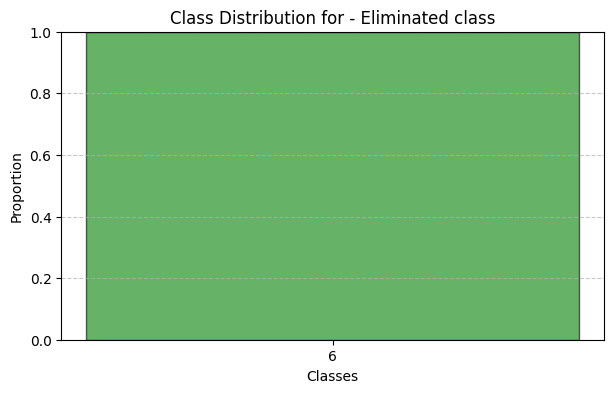

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Function to calculate class ratios and display them
def display_class_ratios_and_plot(labels, set_name):
    class_counts = Counter(labels)  # Count the occurrences of each class
    total = sum(class_counts.values())  # Calculate the total number of labels

    classes = sorted(class_counts.keys())  # Sort the class labels
    ratios = [class_counts[cls] / total for cls in classes]  # Calculate ratios

    # Display the class ratios
    print(f"Class ratios for {set_name}:")
    for cls, count in sorted(class_counts.items()):
        proportion = count / total
    print()

    # Create a bar plot for the class ratios
    plt.figure(figsize=(7, 4))
    plt.bar(classes, ratios, color='green', alpha=0.6, edgecolor='black')
    plt.title(f"Class Distribution for - {set_name}")
    plt.xlabel("Classes")
    plt.ylabel("Proportion")
    plt.xticks(classes)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

display_class_ratios_and_plot(y_train, "Training")
display_class_ratios_and_plot(y_test, "Test")
display_class_ratios_and_plot(y_omitted, "Eliminated class")


In [ ]:
y_train = y_train.astype(floatX)
y_val = y_val.astype(floatX)
y_test = y_test.astype(floatX)
y_unknown = y_omitted.astype(floatX)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)
print(X_omitted.shape, y_unknown.shape)

(576, 64) (576,)
(144, 64) (144,)
(181, 64) (181,)
(181, 64) (181,)


In [ ]:
def construct_bnn(network_input, bnn_output, hidden_layer_neurons, class_nr):
    # Initialize random weights between each layer
    init_weights = {
        "in_1": rng.standard_normal(size=(network_input.shape[1], hidden_layer_neurons)).astype(floatX),
        "1_2": rng.standard_normal(size=(hidden_layer_neurons, hidden_layer_neurons)).astype(floatX),
        "2_out": rng.standard_normal(size=(hidden_layer_neurons, class_nr)).astype(floatX),
    }

    # Define coords parameter for training the model
    coords = {
        "hidden_layer_1": np.arange(hidden_layer_neurons),
        "hidden_layer_2": np.arange(hidden_layer_neurons),
        "output_layer": np.arange(class_nr),
        "train_cols": np.arange(network_input.shape[1]),
    }

    with pm.Model(coords=coords) as bayesian_neural_network:
        # Input and output data for the model
        network_input = pm.Data("network_input", X_train, dims=("obs_id", "train_cols"))
        bnn_output = pm.Data("bnn_output", y_train, dims="obs_id")

        # Weights initialization for each layer
        weights = {
            "in_1": pm.Normal("w_in_1", mu=0, sigma=1, initval=init_weights["in_1"], dims=("train_cols", "hidden_layer_1")),
            "1_2": pm.Normal("w_1_2", mu=0, sigma=1, initval=init_weights["1_2"], dims=("hidden_layer_1", "hidden_layer_2")),
            "2_out": pm.Normal("w_2_out", mu=0, sigma=1, initval=init_weights["2_out"], dims=("hidden_layer_2", "output_layer")),
        }

        # Build the Bayesian neural network with tanh activation functions
        act_1 = pm.math.tanh(pm.math.dot(network_input, weights["in_1"]))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights["1_2"]))
        act_out = pm.math.softmax(pm.math.dot(act_2, weights["2_out"]), axis=-1)

        # Multiclass classification with Categorical likelihood
        out = pm.Categorical("out", p=act_out, observed=bnn_output, total_size=y_train.shape[0], dims="obs_id")
        act_out = pm.Deterministic("act_out", act_out)

    return bayesian_neural_network


In [ ]:
hidden_layer_neurons = 16
class_nr = len(set(y_train))

bnn_model = construct_bnn(X_train, y_train, hidden_layer_neurons, class_nr)

In [ ]:
with bnn_model:
  approx = pm.fit(n=18000)

Output()

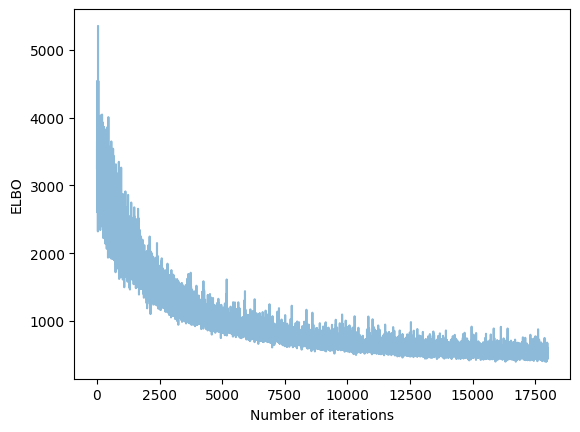

In [ ]:
plt.plot(approx.hist, alpha=0.5)
plt.ylabel("ELBO")
plt.xlabel("Number of iterations")
plt.show()

In [ ]:
trace = approx.sample(draws=4000)
with bnn_model:
  pm.set_data({"network_input": X_val, "bnn_output": y_val}, coords={
    "hidden_layer_1": np.arange(hidden_layer_neurons),
    "hidden_layer_2": np.arange(hidden_layer_neurons),
    "output_layer": np.arange(class_nr),
    "train_cols": np.arange(X_val.shape[1])
  })
  ppc = pm.sample_posterior_predictive(trace, var_names=["out", "act_out"])
  trace.extend(ppc)

Output()

In [ ]:
trace = approx.sample(draws=4000)
with bnn_model:
  pm.set_data({"network_input": X_test}, coords={
    "hidden_layer_1": np.arange(hidden_layer_neurons),
    "hidden_layer_2": np.arange(hidden_layer_neurons),
    "output_layer": np.arange(class_nr),
    "train_cols": np.arange(X_test.shape[1])

  })
  ppc = pm.sample_posterior_predictive(trace, var_names=["out", "act_out"])
  trace.extend(ppc)

Output()

In [ ]:
def calculate_accuracy(ppc, y_test, floatX):

   # Calculate predictions and accuracy of a model based on posterior predictive samples.

    preds = []

    # Iterate through each test point
    for test_point in range(ppc['out'].shape[2]):
        class_votes = []  # List for votes of each class

        for draw in ppc['out'][0]:  # Each draw from the posterior predictive
            class_votes.append(draw[test_point])

        # Determine the class with the most votes
        predicted_class = np.argmax(np.bincount(class_votes))
        preds.append(predicted_class.astype(floatX))

    # Convert the list of predictions into an array
    preds = np.array(preds)

    # Calculate accuracy
    accuracy = (preds == y_test).mean()
    print(f"Accuracy: {accuracy}")

    return preds, accuracy

preds, accuracy = calculate_accuracy(ppc.posterior_predictive, y_test, floatX)


Accuracy: 0.9502762430939227


UNCERTANTY

Predictions shape: (1, 4000, 181, 5)


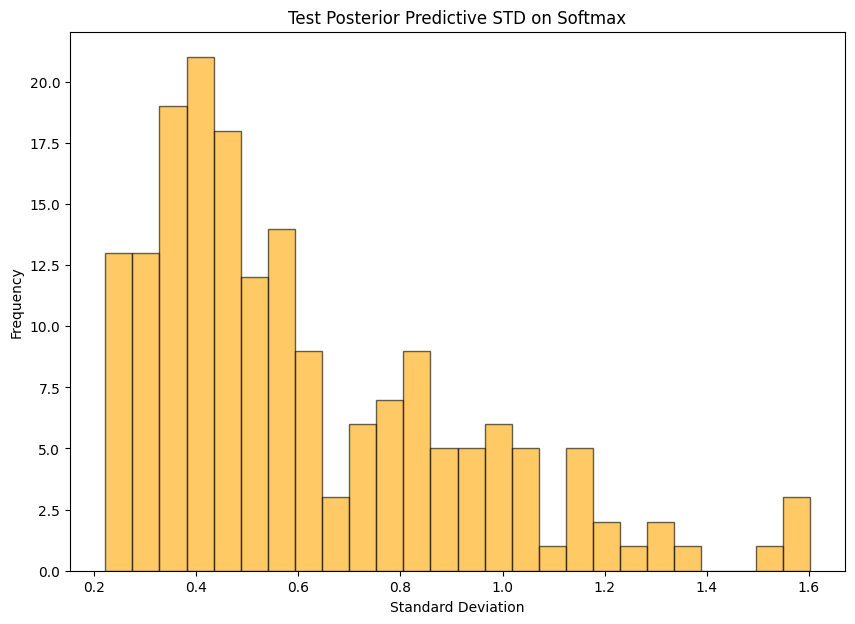

Number of test points: 181


In [ ]:
def calc_unceirtanty(predictions, label='Test'):
    # Calculate total uncertainty (sum of standard deviations) for each test point.

    print(f"Predictions shape: {predictions.shape}")

    # Calculate total uncertainty for each test point
    uncertainty_array = np.array([
        np.std(predictions[0, :, test_idx, :], axis=0).sum()
        for test_idx in range(predictions.shape[2])
    ])

    # Visualize the uncertainty distribution
    plt.figure(figsize=(10, 7))
    plt.hist(uncertainty_array, bins=26, color='orange', alpha=0.6, edgecolor='black')
    plt.title(f"{label} Posterior Predictive STD on Softmax")
    plt.xlabel("Standard Deviation")
    plt.ylabel("Frequency")
    plt.show()

    return uncertainty_array


# Call the function with the posterior predictive results
uncertainty_array = calc_unceirtanty(ppc.posterior_predictive['act_out'], label='Test')

# Print the length of the uncertainty array
print(f"Number of test points: {len(uncertainty_array)}")


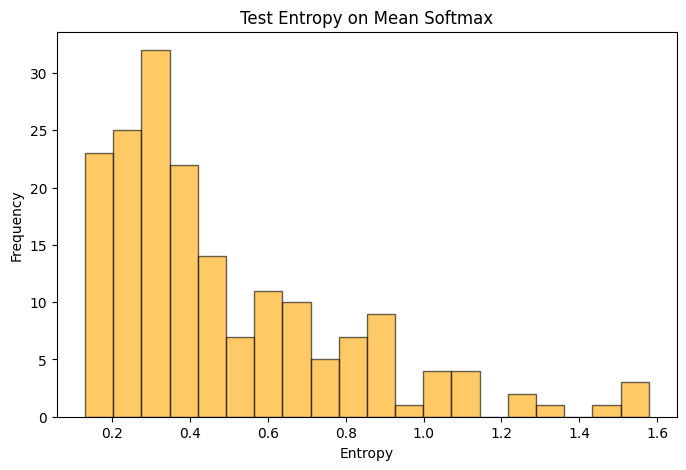

In [ ]:
def compute_entropy(probabilities, epsilon=1e-10):
    # Calculate the entropy for a set of probabilities.

    total_entropy = np.sum(probabilities * np.log(probabilities + epsilon))
    return -total_entropy


def calculate_mean_entropy(predictions, label='Test', epsilon=1e-10):

    # Calculate uncertainty based on the entropy of the mean softmax for each test point.

    uncertainty_values = []

    # Iterate through each test point
    for test_idx in range(predictions.shape[2]):
        # Extract softmax predictions for the current test point
        softmax_draws = predictions[0, :, test_idx, :]  # Shape: (n_draws, n_classes)

        # Convert to numpy array if it's a Pandas object
        if hasattr(softmax_draws, "values"):
            softmax_draws = softmax_draws.values

        # Calculate the mean probability for each class
        averaged_probs = np.mean(softmax_draws, axis=0)  # Shape: (n_classes,)

        # Calculate the entropy of the mean probabilities
        point_entropy = compute_entropy(averaged_probs, epsilon)

        # Save the entropy for the current test point
        uncertainty_values.append(point_entropy)

    # Convert the list of uncertainties into a numpy array
    uncertainty_array = np.array(uncertainty_values)

    # Visualize the uncertainty distribution (histogram)
    plt.figure(figsize=(8, 5))
    plt.hist(uncertainty_array, bins=20, color='orange', alpha=0.6, edgecolor='black')
    plt.title(f"{label} Entropy on Mean Softmax")
    plt.xlabel("Entropy")
    plt.ylabel("Frequency")
    plt.show()

    return uncertainty_array


# Call the function with posterior predictive results
uncertainty_array = calculate_mean_entropy(ppc.posterior_predictive['act_out'], label='Test')


TEST on the Omitted Class

I analyzed the standard deviation chart and concluded that the chosen threshold to determine whether a sample belongs to the unknown class is 1.0.

In [ ]:
trace = approx.sample(draws=4000)
with bnn_model:
  pm.set_data({"network_input": X_omitted, "bnn_output": y_omitted}, coords={
    "hidden_layer_1": np.arange(hidden_layer_neurons),
    "hidden_layer_2": np.arange(hidden_layer_neurons),
    "output_layer": np.arange(class_nr),
    "train_cols": np.arange(X_val.shape[1])
  })
  ppc = pm.sample_posterior_predictive(trace, var_names=["out", "act_out"])
  trace.extend(ppc)

Output()

In [ ]:
preds_omitted, accuracy_omitted = calculate_accuracy(ppc.posterior_predictive, y_omitted, floatX)

Accuracy: 0.0


Accuracy: 0.2430939226519337
Predictions shape: (1, 4000, 181, 5)


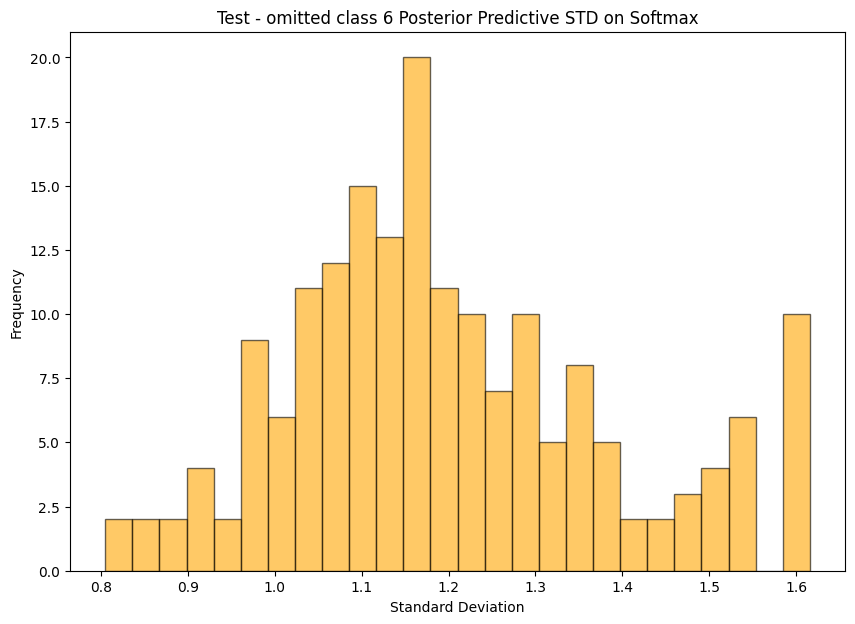

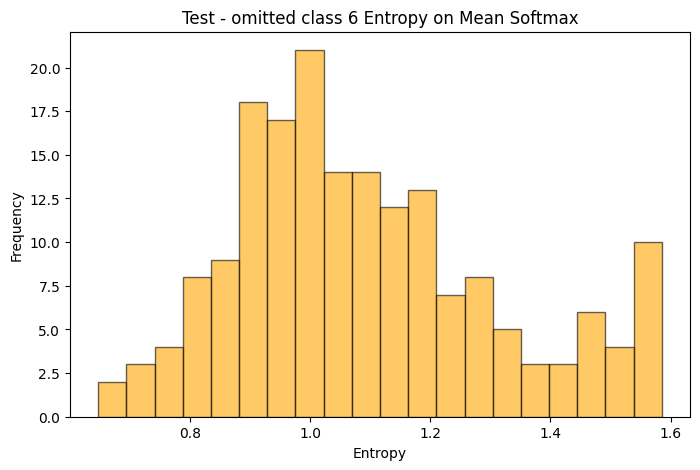

array([1.10820976, 0.75855164, 1.34149433, 0.95088692, 0.9967097 ,
       1.08151573, 1.50000315, 1.22512795, 1.17068848, 0.94506048,
       0.89890789, 0.9108209 , 0.92330461, 1.1606659 , 1.03874338,
       1.14008219, 0.96641469, 1.29266331, 0.8456505 , 1.17259117,
       0.91294429, 1.20020168, 0.89011568, 0.72475178, 1.16210445,
       0.98292869, 0.94945285, 1.0163722 , 1.23900396, 1.12270988,
       1.14068831, 1.30463441, 1.4892563 , 1.00916874, 1.1545161 ,
       1.37450744, 0.99365544, 1.11852002, 0.78939883, 0.92050199,
       1.06410126, 1.08448781, 1.29641421, 0.81763762, 0.70975133,
       1.05433109, 1.11474992, 1.04411966, 1.12390902, 0.64761966,
       1.09349512, 1.45316535, 1.25601577, 1.18594143, 1.35694612,
       1.23479572, 1.01822292, 1.08517648, 0.97139001, 1.00548988,
       1.09624056, 1.20243589, 1.40371476, 1.0412697 , 1.28846764,
       0.94848618, 1.06062053, 0.85835072, 1.1796782 , 0.988267  ,
       0.97095587, 0.93191072, 0.89929672, 1.47819355, 1.10209

In [ ]:
preds_omitted, accuracy_omitted = calculate_accuracy(ppc.posterior_predictive, y_test, floatX)
uncertainty_array = calc_unceirtanty(ppc.posterior_predictive['act_out'], label='Test - omitted class 6')
len(uncertainty_array)
calculate_mean_entropy(ppc.posterior_predictive['act_out'], label='Test - omitted class 6')


Apply the threshold, see the accuracy

Build a Neural Network and comparing the results.





In [ ]:
def classifier_from_threshold(uncertainty_array, threshold):
    classifications = (uncertainty_array > threshold).astype(int)
    unknown_indices = np.where(classifications == 1)[0]
    return classifications, unknown_indices


In [ ]:
# Setting the threshold
threshold = 0.55

# Apply the classification function
classifications, unknown_indices = classifier_from_threshold(uncertainty_array, threshold)

print(f"Total samples: {len(uncertainty_array)}")
print(f"Samples classified as unknown: {len(unknown_indices)}")
print(f"Indices of unknown samples: {unknown_indices}")


Total samples: 181
Samples classified as unknown: 181
Indices of unknown samples: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180]


In [ ]:
X_test_augmented = np.vstack([X_test, X_omitted[:15]])
y_test_augmented = np.concatenate([y_test, y_omitted[:15]])


In [ ]:
trace = approx.sample(draws=4000)
with bnn_model:
  pm.set_data({"network_input": X_test_augmented, "bnn_output": y_test_augmented}, coords={
    "hidden_layer_1": np.arange(hidden_layer_neurons),
    "hidden_layer_2": np.arange(hidden_layer_neurons),
    "output_layer": np.arange(class_nr),
    "train_cols": np.arange(X_val.shape[1])
  })
  ppc = pm.sample_posterior_predictive(trace, var_names=["out", "act_out"])
  trace.extend(ppc)

Output()

[1. 2. 3. 3. 4. 3. 0. 1. 1. 0. 3. 2. 1. 4. 2. 3. 4. 0. 1. 3. 3. 1. 3. 2.
 1. 2. 1. 1. 1. 0. 2. 1. 1. 2. 2. 0. 4. 2. 1. 3. 2. 0. 0. 1. 0. 0. 0. 2.
 2. 1. 3. 2. 4. 1. 4. 4. 4. 0. 3. 1. 1. 4. 2. 3. 0. 4. 2. 4. 1. 3. 3. 0.
 2. 2. 4. 4. 4. 3. 2. 0. 4. 2. 1. 3. 4. 3. 0. 1. 4. 4. 2. 1. 0. 2. 3. 4.
 2. 4. 4. 1. 2. 4. 3. 4. 4. 4. 4. 1. 0. 3. 4. 0. 0. 0. 3. 3. 3. 3. 3. 2.
 3. 2. 4. 1. 4. 0. 1. 4. 1. 0. 1. 0. 4. 0. 1. 2. 0. 4. 3. 3. 4. 3. 1. 2.
 4. 3. 1. 3. 3. 0. 3. 4. 1. 2. 4. 0. 3. 1. 1. 1. 1. 4. 2. 3. 1. 3. 2. 1.
 1. 0. 1. 1. 3. 4. 0. 1. 0. 3. 4. 1. 4. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6.]
15
Predictions shape: (1, 4000, 196, 5)


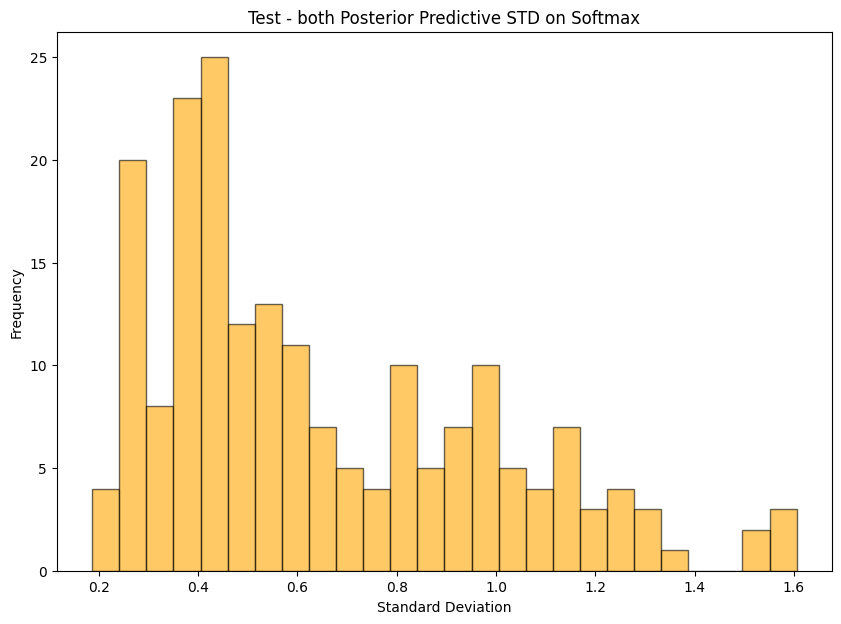

Total samples: 196
Samples classified as unknown: 35


In [ ]:
print(y_test_augmented)
print(np.sum(y_test_augmented == 6) )
uncertainty_array = calc_unceirtanty(ppc.posterior_predictive['act_out'], label='Test - both')
classifications, unknown_indices = classifier_from_threshold(uncertainty_array, threshold= 1.0)

print(f"Total samples: {len(uncertainty_array)}")
print(f"Samples classified as unknown: {len(unknown_indices)}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score


In [ ]:
class NormalNeuralNetwork(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(NormalNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Initial configuration
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))
np.unique(y_train)

array([0., 1., 2., 3., 4.])

In [ ]:
X_tens_train = torch.tensor(X_train, dtype=torch.float32)
y_tens_train = torch.tensor(y_train, dtype=torch.long)

X_tens_val = torch.tensor(X_val, dtype=torch.float32)
y_tens_val = torch.tensor(y_val, dtype=torch.long)

X_tens_test = torch.tensor(X_test, dtype=torch.float32)
y_tens_test = torch.tensor(y_test, dtype=torch.long)


In [ ]:
# Initializing the model
model = NormalNeuralNetwork(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

In [ ]:
# Function for training
def train_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0

        # Training on batches
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            optimizer.zero_grad()  # Reset the gradients
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()  # Calculate gradients
            optimizer.step()  # Update parameters

            epoch_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()

        # Evaluation on the validation set
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_preds = val_outputs.argmax(dim=1)
            val_accuracy = (val_preds == y_val).float().mean().item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {correct/X_train.shape[0]:.4f}, Val Accuracy: {val_accuracy:.4f}")


In [ ]:
train_model(model, X_tens_train, y_tens_train, X_tens_val, y_tens_val, epochs=5)


Epoch 1/5, Loss: 16.2872, Train Accuracy: 1.0000, Val Accuracy: 0.9861
Epoch 2/5, Loss: 16.2871, Train Accuracy: 1.0000, Val Accuracy: 0.9861
Epoch 3/5, Loss: 16.2871, Train Accuracy: 1.0000, Val Accuracy: 0.9861
Epoch 4/5, Loss: 16.2871, Train Accuracy: 1.0000, Val Accuracy: 0.9861
Epoch 5/5, Loss: 16.2871, Train Accuracy: 1.0000, Val Accuracy: 0.9861


In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_tens_test)
    test_preds = test_outputs.argmax(dim=1)
    test_accuracy = accuracy_score(y_test, test_preds.numpy())
    print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9724
